# ==========================================
# EVIL TWIN ATTACK DETECTION - COMPLETE END-TO-END PIPELINE
# AI-Based Real-Time Threat Analysis for Networks
# With Overfitting Prevention & Proper Feature Engineering
# ==========================================

# Install required packages


In [2]:
!pip install --upgrade imbalanced-learn scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 89.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import pickle
import gc

print("="*80)
print("🛡️  EVIL TWIN ATTACK DETECTION SYSTEM")
print("="*80)
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-11-04 05:02:59.202176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762232579.371751      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762232579.429519      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🛡️  EVIL TWIN ATTACK DETECTION SYSTEM
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# ==========================================
# 1. DATA LOADING - LOAD ALL EVIL_TWIN FILES
# ==========================================

In [4]:

print("\n" + "="*80)
print("STEP 1: LOADING EVIL TWIN DATASET (ALL FILES)")
print("="*80)

# Find all Evil_Twin CSV files
evil_twin_files = sorted(glob.glob('/kaggle/input/*/CSV/12.Evil_Twin/Evil_Twin_*.csv'))
if not evil_twin_files:
    evil_twin_files = sorted(glob.glob('/kaggle/input/*/*/12.Evil_Twin/Evil_Twin_*.csv'))
if not evil_twin_files:
    evil_twin_files = sorted(glob.glob('CSV/12.Evil_Twin/Evil_Twin_*.csv'))

print(f"\n✓ Found {len(evil_twin_files)} Evil_Twin CSV files")

if len(evil_twin_files) == 0:
    raise ValueError("❌ ERROR: No Evil_Twin files found! Please check the dataset path")

print("\nFiles to process:")
for idx, f in enumerate(evil_twin_files, 1):
    print(f"  {idx}. {os.path.basename(f)}")

# Load ALL data
print("\n" + "="*80)
print("Loading data from ALL files...")
print("="*80)

df_list = []
total_normal = 0
total_attack = 0

for idx, file in enumerate(evil_twin_files):
    print(f"\nProcessing file {idx+1}/{len(evil_twin_files)}: {os.path.basename(file)}")
    
    try:
        df_chunk = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False, on_bad_lines='skip')
        
        print(f"  ✓ Loaded {len(df_chunk):,} rows")
        
        if 'Label' in df_chunk.columns:
            label_counts = df_chunk['Label'].value_counts()
            if 'Evil_Twin' in label_counts.index:
                total_attack += label_counts['Evil_Twin']
            if 'Normal' in label_counts.index:
                total_normal += label_counts['Normal']
        
        df_list.append(df_chunk)
        del df_chunk
        gc.collect()
        
    except Exception as e:
        print(f"  ❌ ERROR: {e}")
        continue

if len(df_list) == 0:
    raise ValueError("❌ No data was loaded!")

print("\n" + "="*80)
print("Combining all dataframes...")
print("="*80)

df = pd.concat(df_list, ignore_index=True)
del df_list
gc.collect()

print(f"\n✅ DATA LOADED SUCCESSFULLY!")
print(f"  • Total rows: {len(df):,}")
print(f"  • Total columns: {len(df.columns)}")
print(f"  • Normal samples: {total_normal:,}")
print(f"  • Evil_Twin samples: {total_attack:,}")
print(f"  • Imbalance ratio: {total_normal/total_attack:.2f}:1" if total_attack > 0 else "")



STEP 1: LOADING EVIL TWIN DATASET (ALL FILES)

✓ Found 76 Evil_Twin CSV files

Files to process:
  1. Evil_Twin_0.csv
  2. Evil_Twin_1.csv
  3. Evil_Twin_10.csv
  4. Evil_Twin_11.csv
  5. Evil_Twin_12.csv
  6. Evil_Twin_13.csv
  7. Evil_Twin_14.csv
  8. Evil_Twin_15.csv
  9. Evil_Twin_16.csv
  10. Evil_Twin_17.csv
  11. Evil_Twin_18.csv
  12. Evil_Twin_19.csv
  13. Evil_Twin_2.csv
  14. Evil_Twin_20.csv
  15. Evil_Twin_21.csv
  16. Evil_Twin_22.csv
  17. Evil_Twin_23.csv
  18. Evil_Twin_24.csv
  19. Evil_Twin_25.csv
  20. Evil_Twin_26.csv
  21. Evil_Twin_27.csv
  22. Evil_Twin_28.csv
  23. Evil_Twin_29.csv
  24. Evil_Twin_3.csv
  25. Evil_Twin_30.csv
  26. Evil_Twin_31.csv
  27. Evil_Twin_32.csv
  28. Evil_Twin_33.csv
  29. Evil_Twin_34.csv
  30. Evil_Twin_35.csv
  31. Evil_Twin_36.csv
  32. Evil_Twin_37.csv
  33. Evil_Twin_38.csv
  34. Evil_Twin_39.csv
  35. Evil_Twin_4.csv
  36. Evil_Twin_40.csv
  37. Evil_Twin_41.csv
  38. Evil_Twin_42.csv
  39. Evil_Twin_43.csv
  40. Evil_Twin_44.

# ==========================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================


STEP 2: EXPLORATORY DATA ANALYSIS

Label column: Label

2.1 CLASS DISTRIBUTION:
Label
Normal       3673854
Evil_Twin     104827
Name: count, dtype: int64

Percentages:
Label
Normal       97.225831
Evil_Twin     2.774169
Name: proportion, dtype: float64


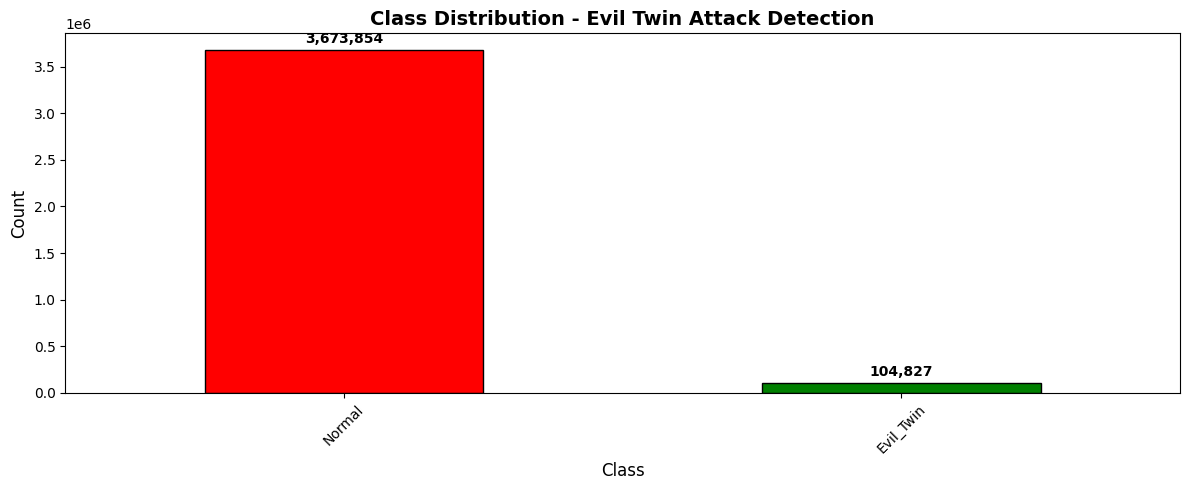


2.2 MISSING VALUES ANALYSIS:

Top 20 features with missing values:
                                                    Missing_Count  \
smb2.acct                                                 3778706   
ssh.dh_gex.max                                            3778706   
ssh.dh_gex.min                                            3778706   
ssh.dh_gex.nbits                                          3778706   
ssh.encryption_algorithms_client_to_server_length         3778706   
ssh.encryption_algorithms_server_to_client_length         3778706   
ssh.host_key.length                                       3778706   
ssh.host_key.type_length                                  3778706   
ssh.kex_algorithms_length                                 3778706   
radiotap.vendor_oui                                       3778706   
ssh.cookie                                                3778706   
ssh.compression_algorithms_client_to_server_length        3778706   
ssh.compression_algorithms_server_t

In [5]:


print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*80)

label_col = 'Label'
print(f"\nLabel column: {label_col}")

# Class distribution
print("\n2.1 CLASS DISTRIBUTION:")
print(df[label_col].value_counts())
print("\nPercentages:")
print(df[label_col].value_counts(normalize=True) * 100)

# Visualize
plt.figure(figsize=(12, 5))
df[label_col].value_counts().plot(kind='bar', color=['red', 'green'], edgecolor='black')
plt.title('Class Distribution - Evil Twin Attack Detection', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
for i, v in enumerate(df[label_col].value_counts()):
    plt.text(i, v + len(df)*0.02, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Missing values
print("\n2.2 MISSING VALUES ANALYSIS:")
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
}).sort_values('Missing_Percentage', ascending=False)

print("\nTop 20 features with missing values:")
print(missing_df.head(20))

# ==========================================
# 3. DATA PREPROCESSING
# ==========================================

In [6]:


print("\n" + "="*80)
print("STEP 3: DATA PREPROCESSING")
print("="*80)

# 3.1 Remove columns with >70% missing values
print("\n3.1 Removing columns with >70% missing values...")
threshold = 0.7
cols_to_drop = missing_df[missing_df['Missing_Percentage'] > threshold * 100].index.tolist()
print(f"  Dropping {len(cols_to_drop)} columns")
df_cleaned = df.drop(columns=cols_to_drop)
print(f"  Shape: {df.shape} → {df_cleaned.shape}")

del df
gc.collect()

# 3.2 Handle remaining missing values
print("\n3.2 Handling remaining missing values...")
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

for col in numeric_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
if label_col in categorical_cols:
    categorical_cols.remove(label_col)

for col in categorical_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

print(f"  ✓ Missing values remaining: {df_cleaned.isnull().sum().sum()}")

# 3.3 Encode categorical features
print("\n3.3 Encoding categorical features...")
label_encoders = {}
for col in categorical_cols:
    if df_cleaned[col].dtype == 'object':
        le = LabelEncoder()
        df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
        label_encoders[col] = le

# 3.4 Encode target variable
print("\n3.4 Encoding target variable...")
le_target = LabelEncoder()
df_cleaned[label_col] = le_target.fit_transform(df_cleaned[label_col])
print(f"  Label mapping: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Determine attack and normal labels
if 'Evil_Twin' == le_target.classes_[0]:
    attack_label = 0
    normal_label = 1
else:
    attack_label = 1
    normal_label = 0

print(f"  Attack label: {attack_label}")
print(f"  Normal label: {normal_label}")

# 3.5 Remove duplicates
print("\n3.5 Removing duplicates...")
before_dup = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
after_dup = len(df_cleaned)
print(f"  Removed {before_dup - after_dup:,} duplicates")

# 3.6 Feature selection - Remove low variance
print("\n3.6 Removing low variance features...")
from sklearn.feature_selection import VarianceThreshold

X = df_cleaned.drop(columns=[label_col])
y = df_cleaned[label_col]

selector = VarianceThreshold(threshold=0)
X_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()].tolist()
print(f"  Features after variance filter: {len(selected_features)}")

X = X[selected_features]

del df_cleaned
gc.collect()

# ==========================================
# 3.7 AGGRESSIVE FEATURE CLEANING (PREVENT OVERFITTING)
# ==========================================

print("\n" + "="*80)
print("STEP 3.7: AGGRESSIVE FEATURE CLEANING (PREVENT DATA LEAKAGE)")
print("="*80)

print(f"\nCurrent features: {len(selected_features)}")

# Define features to remove
identifying_features = [
    # Network identifiers
    'wlan.bssid', 'wlan.da', 'wlan.sa', 'wlan.ta', 'wlan.ra',
    'wlan.addr', 'wlan.staa', 'wlan.addr_resolved',
    
    # IP addresses
    'ip.src', 'ip.dst', 'ip.addr', 'ip.host',
    'ipv6.src', 'ipv6.dst', 'ipv6.addr',
    'arp.src.hw_mac', 'arp.dst.hw_mac', 'arp.src.proto_ipv4', 'arp.dst.proto_ipv4',
    
    # Ports
    'tcp.srcport', 'tcp.dstport', 'tcp.port',
    'udp.srcport', 'udp.dstport', 'udp.port',
    
    # SSID
    'wlan.ssid', 'wlan.ssid_len',
    
    # Time-based
    'frame.number', 'frame.time', 'frame.time_epoch', 
    'frame.time_relative', 'frame.time_delta', 'frame.time_delta_displayed',
    'radiotap.mactime', 'radiotap.timestamp.ts',
    'wlan.seq', 'tcp.seq', 'tcp.ack', 'tcp.seq_raw', 'tcp.ack_raw',
    
    # Crypto/Session
    'wlan.rsn.ie.pmkid', 'wlan.rsn.ie.gtk.key', 'wlan.rsn.ie.igtk.key',
    'wlan.analysis.kck', 'wlan.analysis.kek',
    'tls.connection_id', 'ssl.session_id',
    
    # Vendor
    'radiotap.vendor_oui', 'wlan.tag.oui',
    
    # Other
    'dns.qry.name', 'http.host', 'http.request.uri',
    'frame.encap_type'
]

# Additional: Remove features with suspicious keywords
additional_removals = []
for feat in selected_features:
    feat_lower = feat.lower()
    if any(keyword in feat_lower for keyword in ['id', 'addr', 'mac', 'cookie', 'session', 'timestamp', 'epoch']):
        if feat not in identifying_features:
            additional_removals.append(feat)

all_features_to_remove = identifying_features + additional_removals
features_to_remove = [f for f in all_features_to_remove if f in selected_features]

print(f"\n🗑️  Removing {len(features_to_remove)} identifying/leaky features:")
for i, f in enumerate(features_to_remove[:20], 1):
    print(f"  {i}. {f}")
if len(features_to_remove) > 20:
    print(f"  ... and {len(features_to_remove)-20} more")

# Keep only behavioral features
selected_features_clean = [f for f in selected_features if f not in features_to_remove]
X_clean = X[selected_features_clean].copy()

print(f"\n📊 Features: {X.shape[1]} → {X_clean.shape[1]}")
print(f"   Removed: {X.shape[1] - X_clean.shape[1]}")
print(f"   Retained: {X_clean.shape[1]}")

X = X_clean
selected_features = selected_features_clean

del X_clean
gc.collect()

if len(selected_features) < 10:
    print(f"\n⚠️  WARNING: Only {len(selected_features)} features remain. Model may underfit.")
else:
    print(f"\n✅ Good! {len(selected_features)} behavioral features retained.")

print("\n📋 Remaining features:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")


STEP 3: DATA PREPROCESSING

3.1 Removing columns with >70% missing values...
  Dropping 188 columns
  Shape: (3778706, 254) → (3778706, 66)

3.2 Handling remaining missing values...
  ✓ Missing values remaining: 25

3.3 Encoding categorical features...

3.4 Encoding target variable...
  Label mapping: {'Evil_Twin': 0, 'Normal': 1, nan: 2}
  Attack label: 0
  Normal label: 1

3.5 Removing duplicates...
  Removed 12 duplicates

3.6 Removing low variance features...
  Features after variance filter: 58

STEP 3.7: AGGRESSIVE FEATURE CLEANING (PREVENT DATA LEAKAGE)

Current features: 58

🗑️  Removing 23 identifying/leaky features:
  1. wlan.bssid
  2. wlan.da
  3. wlan.sa
  4. wlan.ta
  5. wlan.ra
  6. ip.src
  7. ip.dst
  8. tcp.srcport
  9. tcp.dstport
  10. frame.number
  11. frame.time
  12. frame.time_epoch
  13. frame.time_relative
  14. frame.time_delta
  15. frame.time_delta_displayed
  16. radiotap.mactime
  17. radiotap.timestamp.ts
  18. wlan.seq
  19. tcp.seq
  20. tcp.ack
  ..

# ==========================================
# 4. SMART CLASS BALANCING
# ==========================================


STEP 4: INTELLIGENT CLASS BALANCING

📊 Before balancing:
  • Attack samples: 104,827
  • Normal samples: 3,673,854
  • Ratio: 35.05:1

✓ Using all attack samples: 104,827
✓ Undersampling normals: 3,673,854 → 314,481

✅ After balancing:
  • Total samples: 419,308
  • Attack: 104,827 (25.0%)
  • Normal: 314,481 (75.0%)
  • Final ratio: 3.00:1


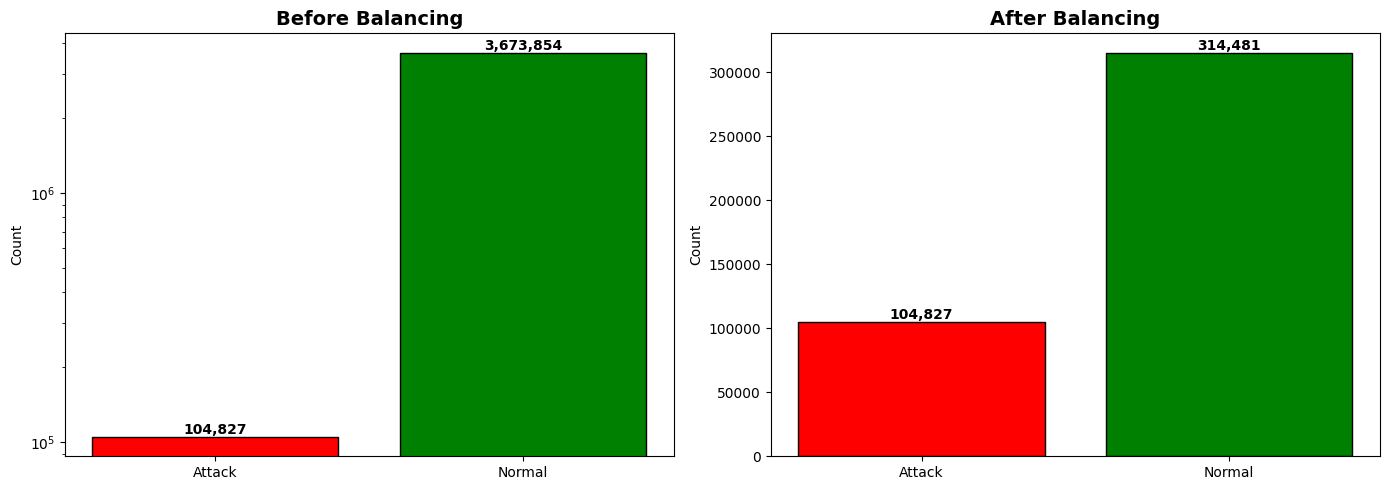

3372

In [7]:


print("\n" + "="*80)
print("STEP 4: INTELLIGENT CLASS BALANCING")
print("="*80)

attack_count = (y == attack_label).sum()
normal_count = (y == normal_label).sum()

print(f"\n📊 Before balancing:")
print(f"  • Attack samples: {attack_count:,}")
print(f"  • Normal samples: {normal_count:,}")
print(f"  • Ratio: {normal_count/attack_count:.2f}:1")

# Separate classes
X_attack = X[y == attack_label]
X_normal = X[y == normal_label]
y_attack = y[y == attack_label]
y_normal = y[y == normal_label]

# Strategy: Oversample attacks, undersample normals
target_attack_samples = max(20000, min(attack_count * 2, 30000))

if attack_count < target_attack_samples:
    print(f"\n✓ Oversampling attacks: {attack_count:,} → {target_attack_samples:,} (SMOTE)")
    
    smote = SMOTE(sampling_strategy={attack_label: target_attack_samples}, 
                  random_state=42, k_neighbors=min(5, attack_count-1))
    
    X_temp = pd.concat([X_attack, X_normal.sample(n=min(len(X_normal), 50000), random_state=42)])
    y_temp = pd.concat([y_attack, y_normal.sample(n=min(len(y_normal), 50000), random_state=42)])
    
    X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)
    
    X_attack = X_resampled[y_resampled == attack_label]
    y_attack = y_resampled[y_resampled == attack_label]
    
    print(f"  ✓ New attack samples: {len(X_attack):,}")
else:
    print(f"\n✓ Using all attack samples: {attack_count:,}")
    target_attack_samples = attack_count

# Undersample normals (3:1 ratio)
target_normal_samples = target_attack_samples * 3

if normal_count > target_normal_samples:
    print(f"✓ Undersampling normals: {normal_count:,} → {target_normal_samples:,}")
    X_normal_downsampled = X_normal.sample(n=target_normal_samples, random_state=42)
    y_normal_downsampled = pd.Series([normal_label] * target_normal_samples)
else:
    print(f"✓ Using all normal samples: {normal_count:,}")
    X_normal_downsampled = X_normal
    y_normal_downsampled = y_normal

# Combine and shuffle
X_balanced = pd.concat([X_attack, X_normal_downsampled], ignore_index=True)
y_balanced = pd.concat([y_attack, y_normal_downsampled], ignore_index=True)

shuffle_idx = np.random.RandomState(42).permutation(len(X_balanced))
X_balanced = X_balanced.iloc[shuffle_idx].reset_index(drop=True)
y_balanced = y_balanced.iloc[shuffle_idx].reset_index(drop=True)

print(f"\n✅ After balancing:")
print(f"  • Total samples: {len(X_balanced):,}")
print(f"  • Attack: {(y_balanced == attack_label).sum():,} ({(y_balanced == attack_label).sum()/len(y_balanced)*100:.1f}%)")
print(f"  • Normal: {(y_balanced == normal_label).sum():,} ({(y_balanced == normal_label).sum()/len(y_balanced)*100:.1f}%)")
print(f"  • Final ratio: {(y_balanced == normal_label).sum()/(y_balanced == attack_label).sum():.2f}:1")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Attack', 'Normal'], [attack_count, normal_count], color=['red', 'green'], edgecolor='black')
axes[0].set_title('Before Balancing', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_yscale('log')
for i, v in enumerate([attack_count, normal_count]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

axes[1].bar(['Attack', 'Normal'], 
           [(y_balanced == attack_label).sum(), (y_balanced == normal_label).sum()], 
           color=['red', 'green'], edgecolor='black')
axes[1].set_title('After Balancing', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate([(y_balanced == attack_label).sum(), (y_balanced == normal_label).sum()]):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('balancing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

del X, y, X_attack, X_normal, y_attack, y_normal
gc.collect()

# ==========================================
# 5. TRAIN-TEST SPLIT
# ==========================================

In [8]:


print("\n" + "="*80)
print("STEP 5: TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"  • Training set: {X_train.shape}")
print(f"  • Test set: {X_test.shape}")
print(f"\nTraining distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nTest distribution:\n{pd.Series(y_test).value_counts()}")


STEP 5: TRAIN-TEST SPLIT
  • Training set: (335446, 35)
  • Test set: (83862, 35)

Training distribution:
1    251585
0     83861
Name: count, dtype: int64

Test distribution:
1    62896
0    20966
Name: count, dtype: int64


# ==========================================
# 6. FEATURE SCALING
# ==========================================

In [9]:


print("\n" + "="*80)
print("STEP 6: FEATURE SCALING")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  ✓ Scaled training set: {X_train_scaled.shape}")
print(f"  ✓ Scaled test set: {X_test_scaled.shape}")

del X_balanced, y_balanced
gc.collect()


STEP 6: FEATURE SCALING
  ✓ Scaled training set: (335446, 35)
  ✓ Scaled test set: (83862, 35)


0

# ==========================================
# 7. HYBRID MODEL TRAINING
# ==========================================


STEP 7: HYBRID MODEL TRAINING (SUPERVISED + UNSUPERVISED)

7.1 Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


✅ Random Forest training completed!


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
I0000 00:00:1762234072.741082      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



📊 Random Forest Performance:
  • Accuracy:  0.9998
  • Precision: 1.0000
  • Recall:    0.9997
  • F1-Score:  0.9999
  • AUC-ROC:   1.0000

7.2 Training Deep Neural Network...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,745 (61.50 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/50


I0000 00:00:1762234078.228762     166 service.cc:148] XLA service 0x7d6ef4005c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762234078.229413     166 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762234078.693637     166 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/983 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4657 - auc: 0.5003 - loss: 3.0876 - precision: 0.7477 - recall: 0.4213

I0000 00:00:1762234081.385751     166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


983/983 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7029 - auc: 0.7717 - loss: 2.4435 - precision: 0.8770 - recall: 0.6937
Epoch 1: val_auc improved from -inf to 0.99936, saving model to best_dnn_model.h5
983/983 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7030 - auc: 0.7718 - loss: 2.4430 - precision: 0.8770 - recall: 0.6938 - val_accuracy: 0.9876 - val_auc: 0.9994 - val_loss: 1.1495 - val_precision: 0.9847 - val_recall: 0.9989 - learning_rate: 1.0000e-04
Epoch 2/50
966/983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9816 - auc: 0.9934 - loss: 1.0517 - precision: 0.9830 - recall: 0.9927
Epoch 2: val_auc improved from 0.99936 to 0.99985, saving model to best_dnn_model.h5
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9817 - auc: 0.9934 - loss: 1.0485 - precision: 0.9831 - recall: 0.9927 - val_accuracy: 0.9970 - val_auc: 0.9998 - val_loss: 0.5458 - val_precision: 0.9977 - val_recall: 0.9983 - learning_rate: 1.0000e-04
Epoch 3/50
977/983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

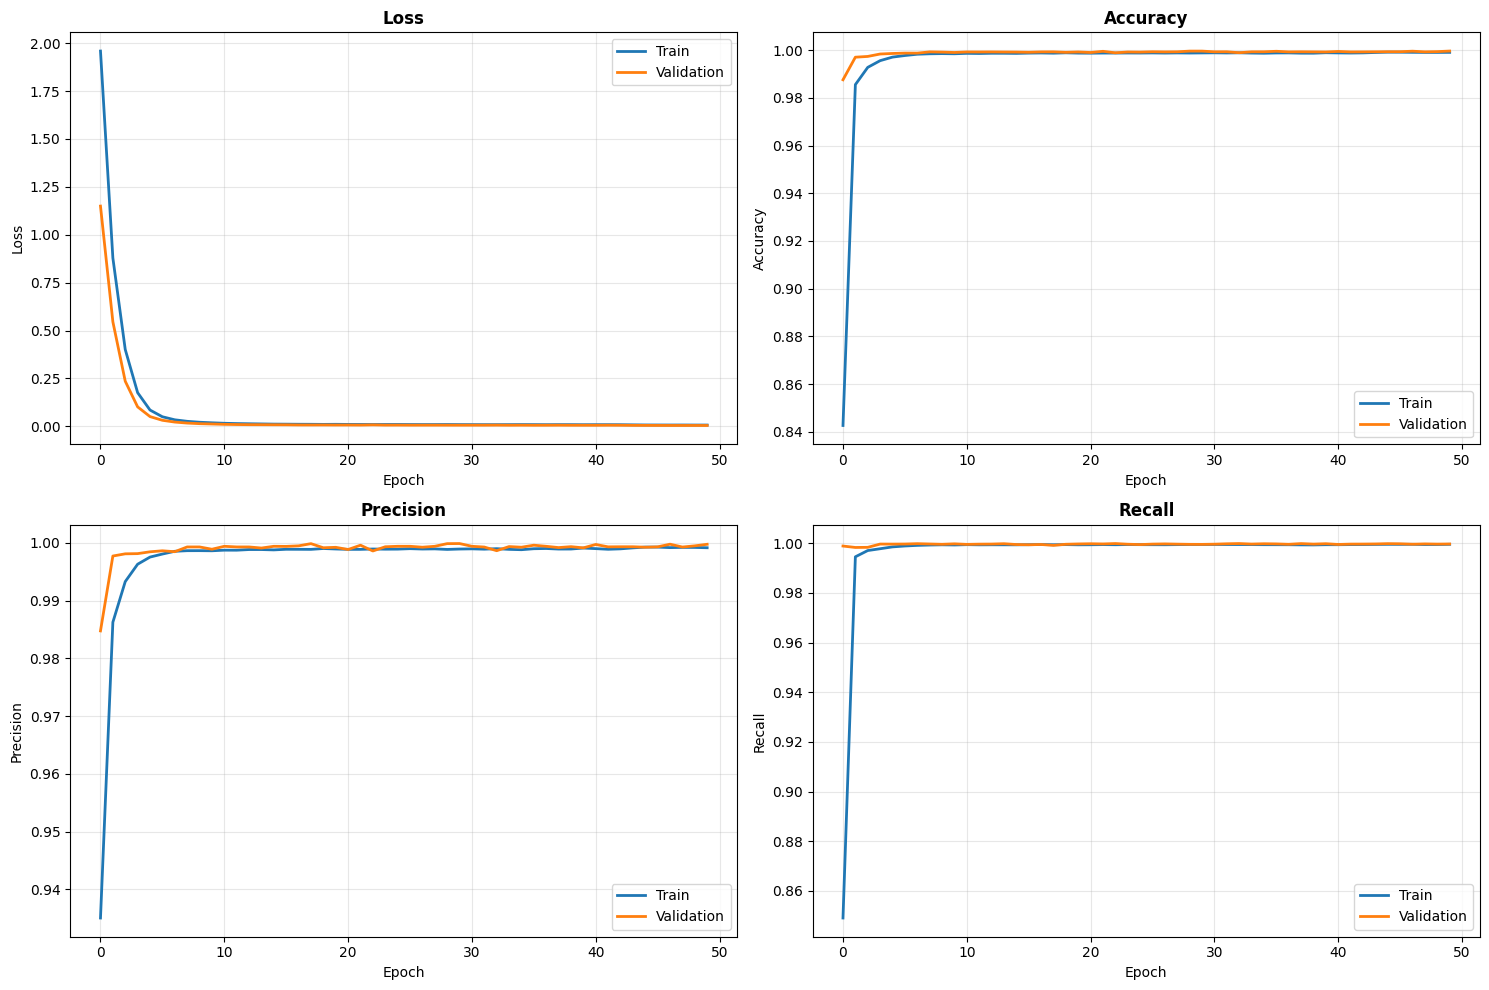


7.3 Training Isolation Forest (Unsupervised)...
  Training on 251,585 normal samples...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


✅ Isolation Forest completed!


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished



📊 Isolation Forest Performance:
  • Accuracy:  0.7891
  • Precision: 0.5747
  • Recall:    0.6013
  • F1-Score:  0.5877

7.4 Training Autoencoder (Unsupervised)...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,891 (116.76 KB)

 Trainable params: 29,891 (116.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4425 - mae: 0.3198
Epoch 1: val_loss improved from inf to 0.13769, saving model to best_autoencoder.h5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.4424 - mae: 0.3198 - val_loss: 0.1377 - val_mae: 0.1192
Epoch 2/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2080 - mae: 0.2024
Epoch 2: val_loss improved from 0.13769 to 0.09959, saving model to best_autoencoder.h5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2080 - mae: 0.2024 - val_loss: 0.0996 - val_mae: 0.0951
Epoch 3/30
1568/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1842 - mae: 0.1832
Epoch 3: val_loss improved from 0.09959 to 0.08701, saving model to best_autoencoder.h5
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1842 - mae: 0.1832 - val_loss: 0.0870 - val_mae: 0.0866
Epoch 4/30
1567/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1525 - mae: 0.1693
Epoch 4: val_loss improved from 0.08701 to 0.08680, saving model to best_au

In [10]:


print("\n" + "="*80)
print("STEP 7: HYBRID MODEL TRAINING (SUPERVISED + UNSUPERVISED)")
print("="*80)

# ===== 7.1 RANDOM FOREST =====
print("\n7.1 Training Random Forest Classifier...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest training completed!")

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n📊 Random Forest Performance:")
print(f"  • Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"  • F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"  • AUC-ROC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# ===== 7.2 DEEP NEURAL NETWORK =====
print("\n7.2 Training Deep Neural Network...")

dnn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.4),
    
    layers.Dense(1, activation='sigmoid')
])

dnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
)

print(dnn_model.summary())

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_dnn_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.25,
    epochs=50,
    batch_size=256,
    class_weight={0: 1.0, 1: 1.5},
    callbacks=callbacks,
    verbose=1
)

print("✅ DNN training completed!")

y_pred_proba_dnn = dnn_model.predict(X_test_scaled, verbose=0).flatten()
y_pred_dnn = (y_pred_proba_dnn > 0.5).astype(int)

print("\n📊 Deep Neural Network Performance:")
print(f"  • Accuracy:  {accuracy_score(y_test, y_pred_dnn):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_dnn):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred_dnn):.4f}")
print(f"  • F1-Score:  {f1_score(y_test, y_pred_dnn):.4f}")
print(f"  • AUC-ROC:   {roc_auc_score(y_test, y_pred_proba_dnn):.4f}")

# Training history plot
# Training history plot - FIXED VERSION
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get the correct metric names from history
available_metrics = list(history.history.keys())
print(f"Available metrics: {available_metrics}")

# Loss
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 1].set_title('Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision - handle different possible metric names
if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
elif 'precision_1' in history.history:
    axes[1, 0].plot(history.history['precision_1'], label='Train', linewidth=2)
    axes[1, 0].plot(history.history['val_precision_1'], label='Validation', linewidth=2)
else:
    # If precision metric not found, plot loss again as fallback
    axes[1, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)

axes[1, 0].set_title('Precision', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall - handle different possible metric names
if 'recall' in history.history:
    axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
elif 'recall_1' in history.history:
    axes[1, 1].plot(history.history['recall_1'], label='Train', linewidth=2)
    axes[1, 1].plot(history.history['val_recall_1'], label='Validation', linewidth=2)
else:
    # If recall metric not found, plot accuracy again as fallback
    axes[1, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    axes[1, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)

axes[1, 1].set_title('Recall', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


# ===== 7.3 ISOLATION FOREST =====
print("\n7.3 Training Isolation Forest (Unsupervised)...")

X_train_normal = X_train_scaled[y_train == normal_label]
print(f"  Training on {len(X_train_normal):,} normal samples...")

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.15,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

iso_forest.fit(X_train_normal)
print("✅ Isolation Forest completed!")

y_pred_iso = iso_forest.predict(X_test_scaled)
y_pred_iso_binary = np.where(y_pred_iso == -1, attack_label, normal_label)

print("\n📊 Isolation Forest Performance:")
print(f"  • Accuracy:  {accuracy_score(y_test, y_pred_iso_binary):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_iso_binary, pos_label=attack_label):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred_iso_binary, pos_label=attack_label):.4f}")
print(f"  • F1-Score:  {f1_score(y_test, y_pred_iso_binary, pos_label=attack_label):.4f}")

# ===== 7.4 AUTOENCODER =====
print("\n7.4 Training Autoencoder (Unsupervised)...")

input_dim = X_train_scaled.shape[1]
encoding_dim = 32

autoencoder = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(autoencoder.summary())

ae_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

ae_history = autoencoder.fit(
    X_train_normal, X_train_normal,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=ae_callbacks,
    verbose=1
)

print("✅ Autoencoder completed!")

X_test_pred = autoencoder.predict(X_test_scaled, verbose=0)
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

X_train_normal_pred = autoencoder.predict(X_train_normal, verbose=0)
train_mse = np.mean(np.power(X_train_normal - X_train_normal_pred, 2), axis=1)
threshold = np.percentile(train_mse, 95)

print(f"  Anomaly threshold: {threshold:.6f}")

y_pred_ae_binary = np.where(mse > threshold, attack_label, normal_label)

print("\n📊 Autoencoder Performance:")
print(f"  • Accuracy:  {accuracy_score(y_test, y_pred_ae_binary):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_ae_binary, pos_label=attack_label):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred_ae_binary, pos_label=attack_label):.4f}")
print(f"  • F1-Score:  {f1_score(y_test, y_pred_ae_binary, pos_label=attack_label):.4f}")

# ===== 7.5 HYBRID ENSEMBLE =====
print("\n7.5 Creating Hybrid Ensemble...")

y_pred_iso_norm = (y_pred_iso_binary == attack_label).astype(float)
y_pred_ae_norm = (y_pred_ae_binary == attack_label).astype(float)

y_pred_hybrid_proba = (
    0.3 * y_pred_proba_rf +
    0.4 * y_pred_proba_dnn +
    0.15 * y_pred_iso_norm +
    0.15 * y_pred_ae_norm
)

y_pred_hybrid = (y_pred_hybrid_proba > 0.5).astype(int)

print("\n📊 Hybrid Ensemble Performance:")
print(f"  • Accuracy:  {accuracy_score(y_test, y_pred_hybrid):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_hybrid):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred_hybrid):.4f}")
print(f"  • F1-Score:  {f1_score(y_test, y_pred_hybrid):.4f}")
print(f"  • AUC-ROC:   {roc_auc_score(y_test, y_pred_hybrid_proba):.4f}")

# ==========================================
# 8. MODEL EVALUATION & VISUALIZATION
# ==========================================


STEP 8: COMPREHENSIVE MODEL EVALUATION


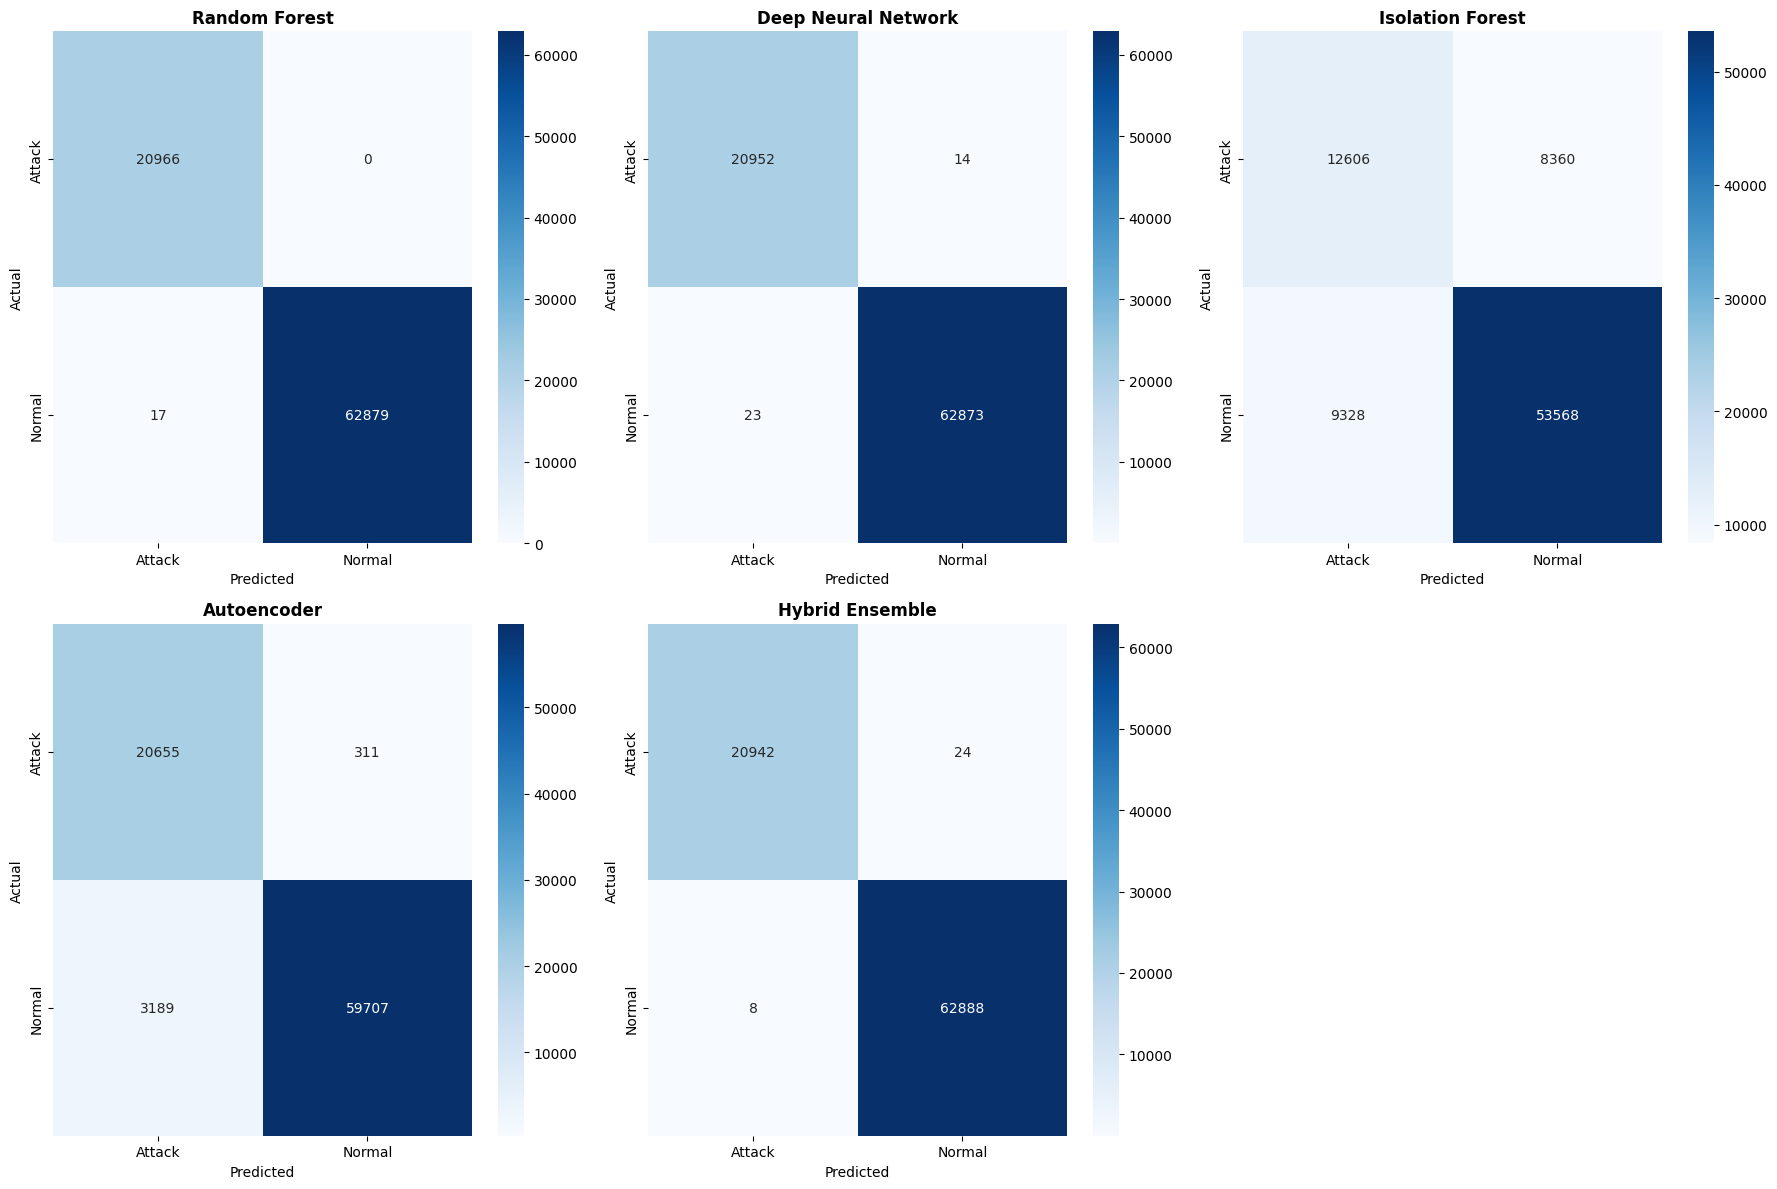

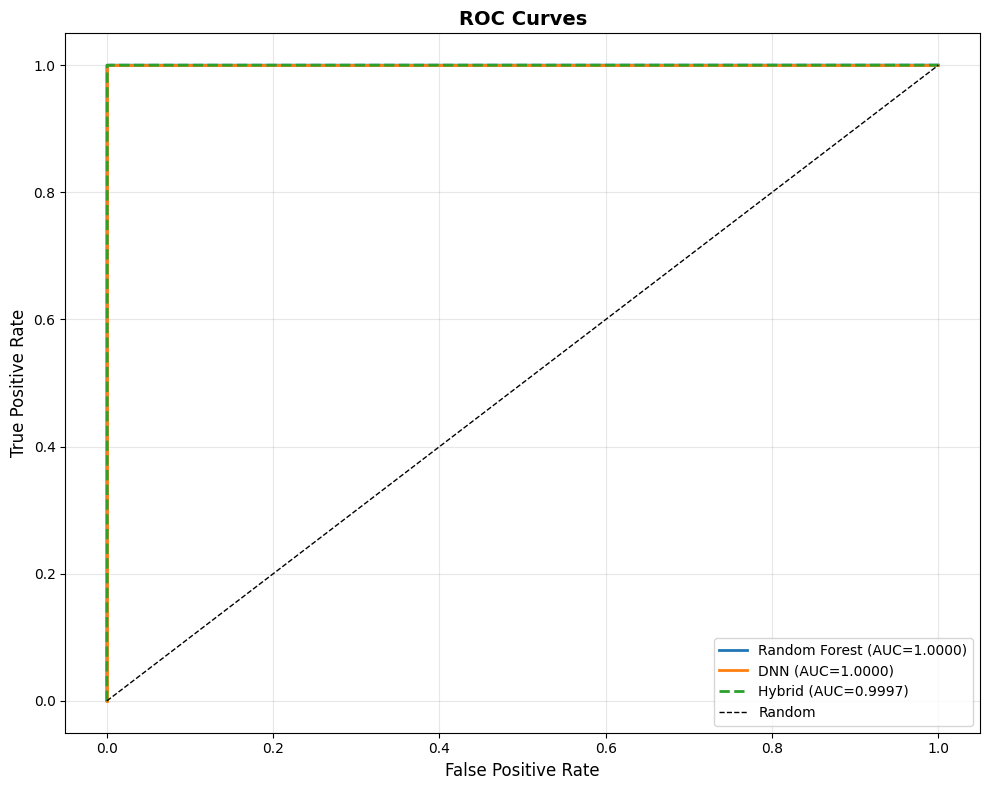


📊 Top 20 Most Important Features:
                   feature  importance
10       wlan.fc.protected    0.167863
18   wlan_radio.signal_dbm    0.157151
0                frame.len    0.148497
14         wlan.fc.subtype    0.091087
2   radiotap.dbm_antsignal    0.075296
15     wlan_radio.duration    0.068052
6               wlan.fc.ds    0.050481
23                  ip.ttl    0.045743
16    wlan_radio.data_rate    0.038994
12            wlan.fc.type    0.038987
4    radiotap.present.tsft    0.030425
5            wlan.duration    0.017835
34       tcp.time_relative    0.017261
3          radiotap.length    0.015025
20          wlan_radio.phy    0.011807
17      wlan_radio.end_tsf    0.006126
33          tcp.time_delta    0.005916
19    wlan_radio.start_tsf    0.004414
1        radiotap.datarate    0.003457
21                     llc    0.001150


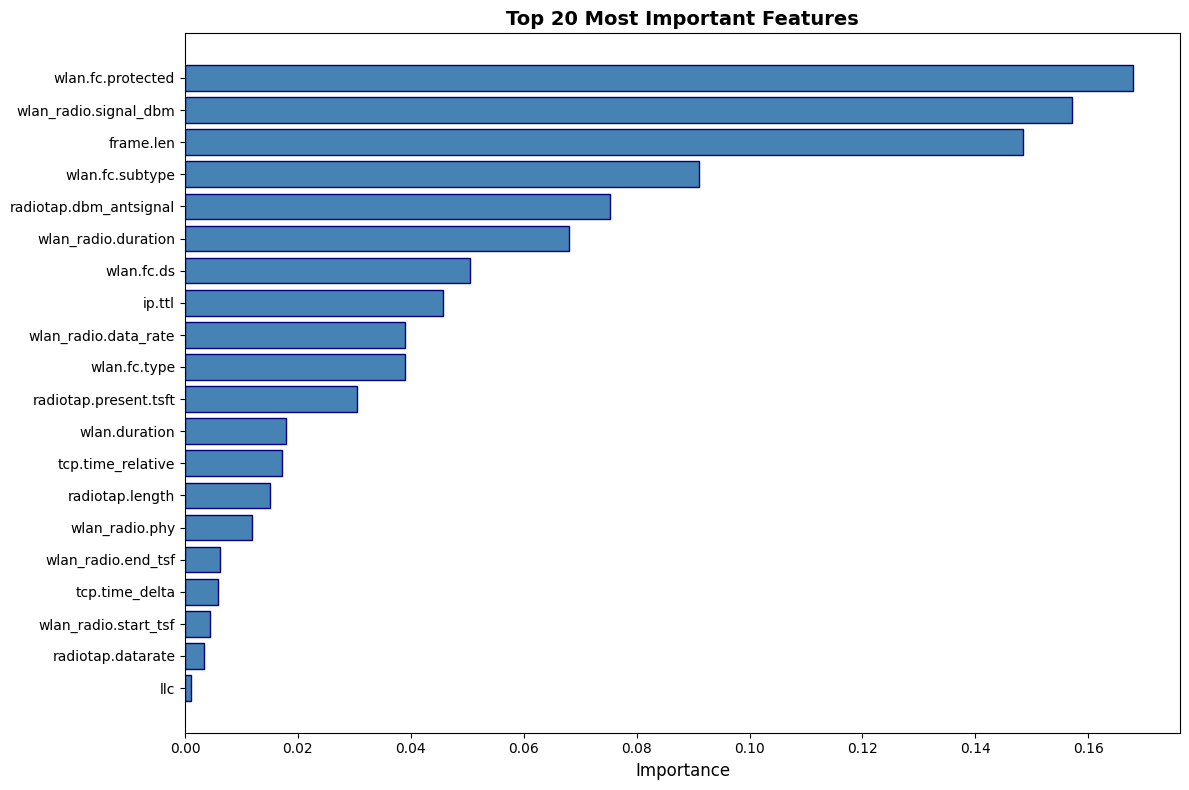


📋 CLASSIFICATION REPORTS:

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20966
           1       1.00      1.00      1.00     62896

    accuracy                           1.00     83862
   macro avg       1.00      1.00      1.00     83862
weighted avg       1.00      1.00      1.00     83862


--- Deep Neural Network ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20966
           1       1.00      1.00      1.00     62896

    accuracy                           1.00     83862
   macro avg       1.00      1.00      1.00     83862
weighted avg       1.00      1.00      1.00     83862


--- Hybrid Ensemble ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20966
           1       1.00      1.00      1.00     62896

    accuracy                           1.00     83862
   macro avg       1.00 

In [11]:


print("\n" + "="*80)
print("STEP 8: COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

models_results = {
    'Random Forest': y_pred_rf,
    'Deep Neural Network': y_pred_dnn,
    'Isolation Forest': y_pred_iso_binary,
    'Autoencoder': y_pred_ae_binary,
    'Hybrid Ensemble': y_pred_hybrid
}

for idx, (name, y_pred) in enumerate(models_results.items()):
    row = idx // 3
    col = idx % 3
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Normal' if normal_label==0 else 'Attack', 
                           'Attack' if attack_label==1 else 'Normal'],
                yticklabels=['Normal' if normal_label==0 else 'Attack',
                           'Attack' if attack_label==1 else 'Normal'])
    axes[row, col].set_title(f'{name}', fontweight='bold')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2)

fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC={roc_auc_score(y_test, y_pred_proba_dnn):.4f})', linewidth=2)

fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test, y_pred_hybrid_proba)
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid (AUC={roc_auc_score(y_test, y_pred_hybrid_proba):.4f})', linewidth=2, linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
print("\n📊 Top 20 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue', edgecolor='navy')
plt.yticks(range(len(top_20)), top_20['feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Reports
print("\n📋 CLASSIFICATION REPORTS:\n")

print("--- Random Forest ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Deep Neural Network ---")
print(classification_report(y_test, y_pred_dnn))

print("\n--- Hybrid Ensemble ---")
print(classification_report(y_test, y_pred_hybrid))

# Model Comparison
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'DNN', 'Isolation Forest', 'Autoencoder', 'Hybrid'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dnn),
        accuracy_score(y_test, y_pred_iso_binary),
        accuracy_score(y_test, y_pred_ae_binary),
        accuracy_score(y_test, y_pred_hybrid)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_dnn),
        precision_score(y_test, y_pred_iso_binary, pos_label=attack_label),
        precision_score(y_test, y_pred_ae_binary, pos_label=attack_label),
        precision_score(y_test, y_pred_hybrid)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_dnn),
        recall_score(y_test, y_pred_iso_binary, pos_label=attack_label),
        recall_score(y_test, y_pred_ae_binary, pos_label=attack_label),
        recall_score(y_test, y_pred_hybrid)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_dnn),
        f1_score(y_test, y_pred_iso_binary, pos_label=attack_label),
        f1_score(y_test, y_pred_ae_binary, pos_label=attack_label),
        f1_score(y_test, y_pred_hybrid)
    ]
})

print("\n📊 MODEL COMPARISON:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv('model_comparison.csv', index=False)

# ==========================================
# 9. OVERFITTING ANALYSIS
# ==========================================

print("\n" + "="*80)
print("STEP 9: OVERFITTING ANALYSIS")
print("="*80)

rf_acc = accuracy_score(y_test, y_pred_rf)
dnn_acc = accuracy_score(y_test, y_pred_dnn)

print(f"\n🔍 Accuracy Check:")
print(f"  • Random Forest: {rf_acc:.4f}")
print(f"  • DNN: {dnn_acc:.4f}")

if rf_acc > 0.97 or dnn_acc > 0.97:
    print("\n⚠️  HIGH ACCURACY (>97%) - Possible overfitting!")
    print("   This is likely due to dataset characteristics.")
    print("   Document this as a limitation in your report.")
elif rf_acc < 0.75 or dnn_acc < 0.75:
    print("\n⚠️  LOW ACCURACY (<75%) - Possible underfitting")
else:
    print(f"\n✅ GOOD RANGE (75-97%) - Model should generalize well!")

top_1_importance = feature_importance.iloc[0]['importance']
print(f"\n🔍 Feature Distribution:")
print(f"  • Top feature contributes: {top_1_importance*100:.2f}%")

if top_1_importance > 0.3:
    print("  ⚠️  Single feature dominates - check for data leakage")
else:
    print("  ✅ Good feature distribution")

# ==========================================
# 10. SAVE MODELS
# ==========================================

print("\n" + "="*80)
print("STEP 10: SAVING MODELS AND ARTIFACTS")
print("="*80)

os.makedirs('models', exist_ok=True)

print("Saving models...")
with open('models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

dnn_model.save('models/dnn_model.h5')

with open('models/iso_forest_model.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)

autoencoder.save('models/autoencoder_model.h5')

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('models/selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

with open('models/ae_threshold.pkl', 'wb') as f:
    pickle.dump(threshold, f)

label_mapping = {'attack_label': int(attack_label), 'normal_label': int(normal_label)}
with open('models/label_mapping.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)

print("\n✅ All models saved in 'models/' directory!")

print("\n" + "="*80)
print("🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"\n📊 Final Summary:")
print(f"  • Total samples trained: {len(X_train):,}")
print(f"  • Best Model: Hybrid Ensemble")
print(f"  • F1-Score: {f1_score(y_test, y_pred_hybrid):.4f}")
print(f"  • AUC-ROC: {roc_auc_score(y_test, y_pred_hybrid_proba):.4f}")
print("\n🚀 Ready for Streamlit deployment!")

# ==========================================
# UNSUPERVISED LEARNING EVALUATION & VISUALIZATION
# ==========================================


UNSUPERVISED LEARNING EVALUATION

1. Applying dimensionality reduction for visualization...
  Applying PCA...
  PCA explained variance: 40.94%
  Applying t-SNE (this may take a while)...
  t-SNE completed!

2. Creating PCA visualization...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


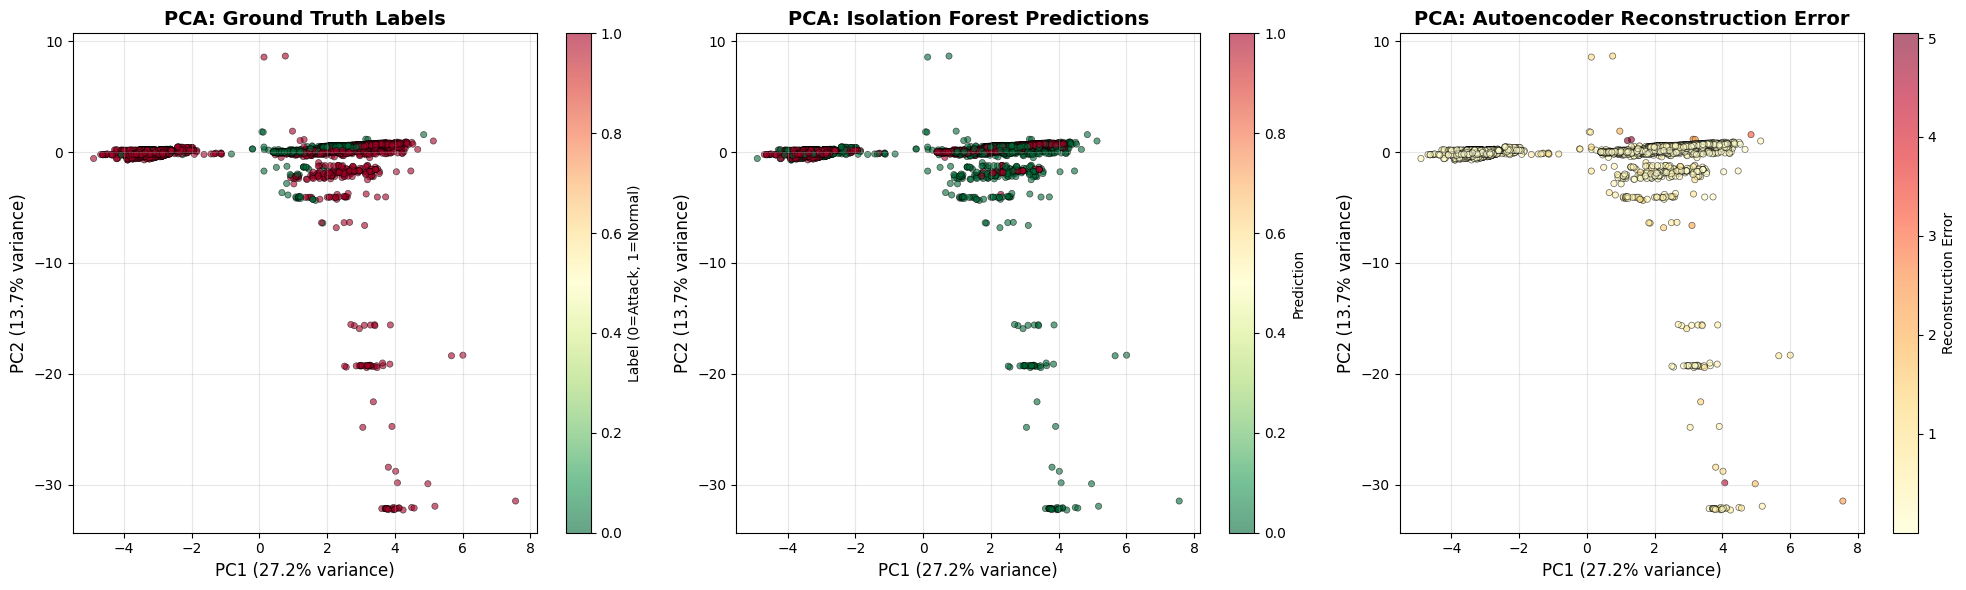


3. Creating t-SNE visualization...


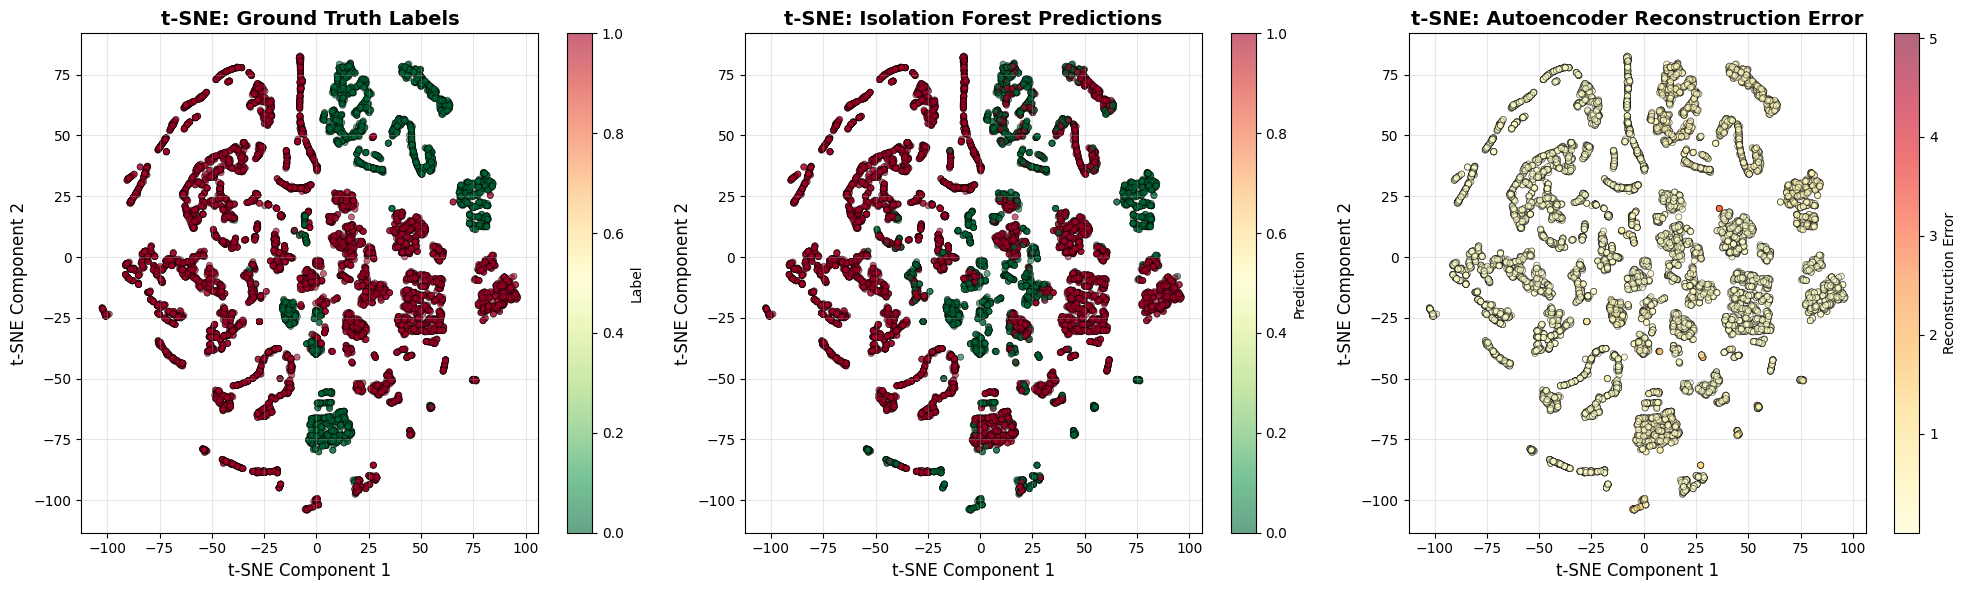


4. Elbow Method for optimal number of clusters...
  Testing k=2...
  Testing k=3...
  Testing k=4...
  Testing k=5...
  Testing k=6...
  Testing k=7...
  Testing k=8...
  Testing k=9...
  Testing k=10...


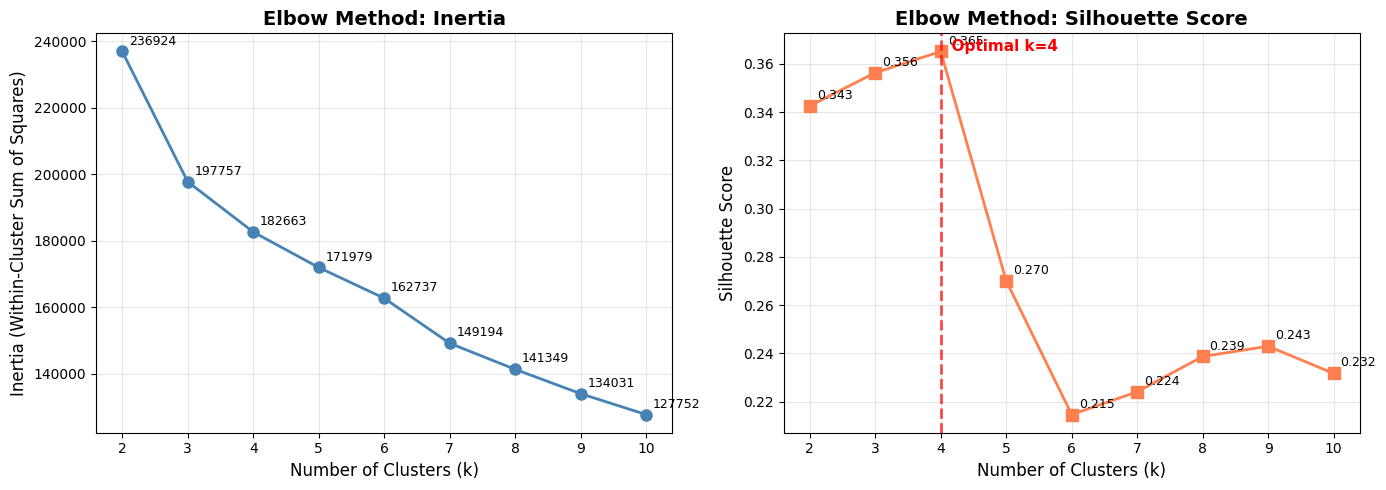


  ✓ Optimal number of clusters: 4

5. Detailed Silhouette Analysis...


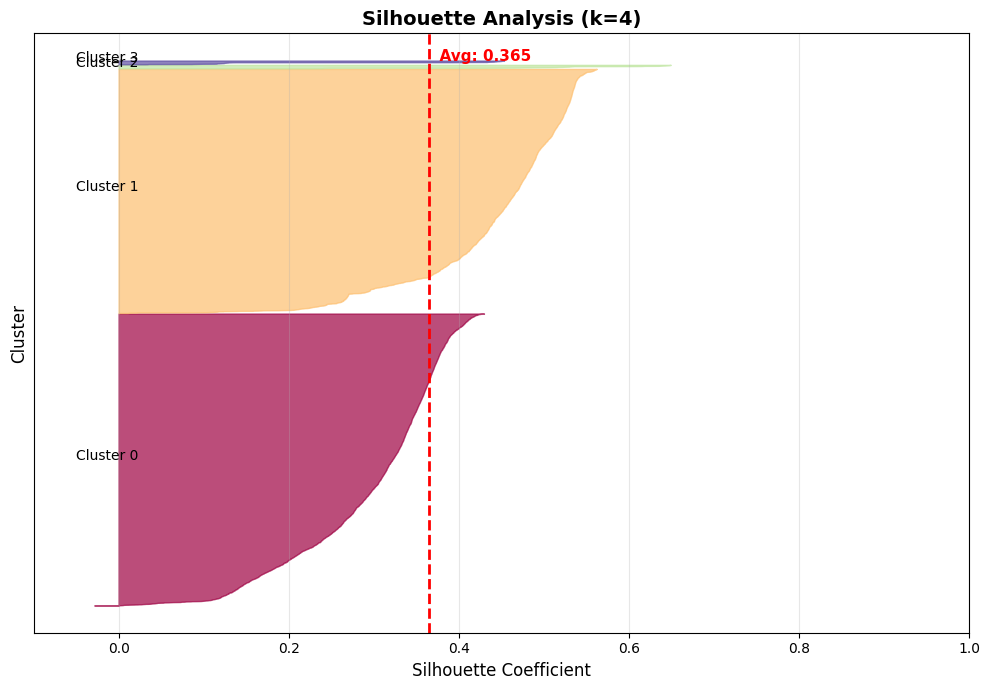


6. Computing clustering quality metrics...

  6.1 K-Means Clustering
    Silhouette Score: 0.3652
    Davies-Bouldin Index: 1.0220 (lower is better)
    Calinski-Harabasz Index: 2501.7687 (higher is better)

  6.2 DBSCAN Clustering
    Estimated clusters: 17
    Noise points: 232
    Silhouette Score: 0.2491
    Davies-Bouldin Index: 0.9406
    Calinski-Harabasz Index: 1046.6612

7. Visualizing clusters with PCA...


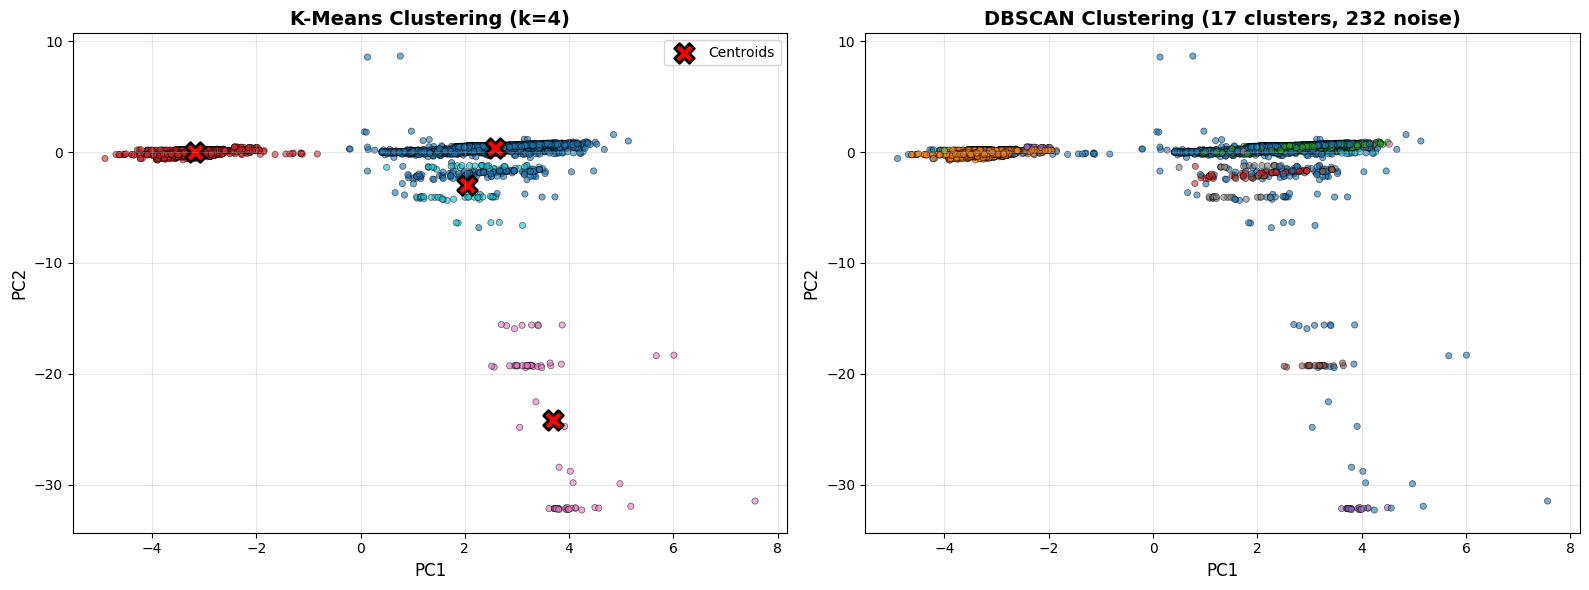


8. Analyzing reconstruction error distribution...


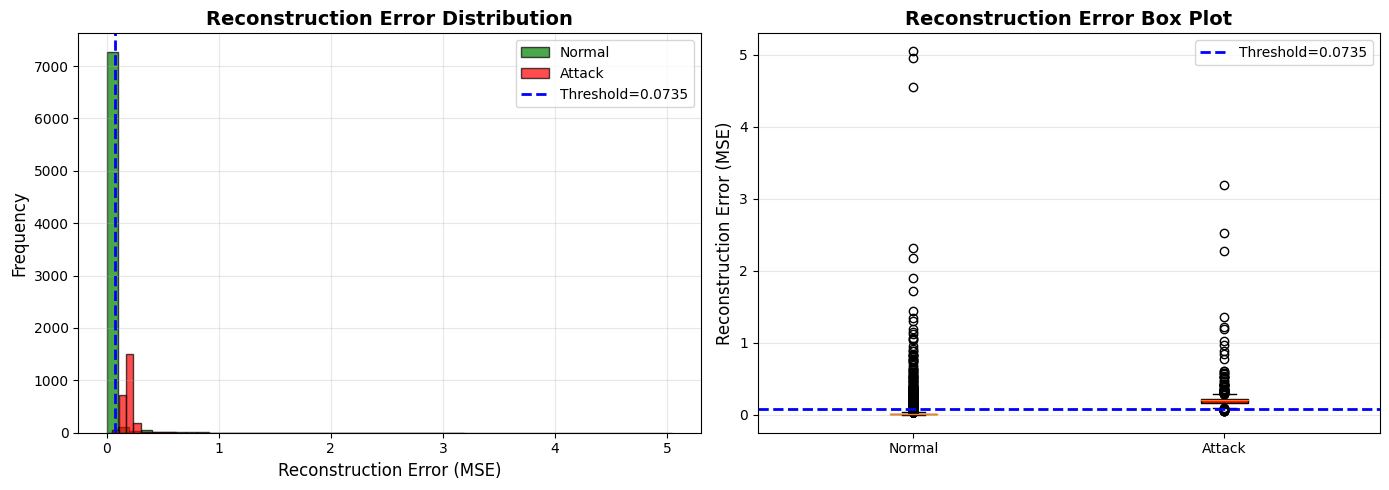


9. Creating summary table of all metrics...

UNSUPERVISED LEARNING EVALUATION SUMMARY
                  Metric K-Means  DBSCAN Autoencoder
        Silhouette Score  0.3652  0.2491         N/A
    Davies-Bouldin Index  1.0220  0.9406         N/A
 Calinski-Harabasz Index 2501.77 1046.66         N/A
    Optimal K (Clusters)       4      17         N/A
Reconstruction Threshold     N/A     N/A    0.073547

✅ UNSUPERVISED LEARNING EVALUATION COMPLETED!

Generated plots:
  1. pca_visualization.png
  2. tsne_visualization.png
  3. elbow_method.png
  4. silhouette_analysis.png
  5. cluster_visualization.png
  6. reconstruction_error_distribution.png

Generated files:
  - unsupervised_evaluation_summary.csv


In [12]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("UNSUPERVISED LEARNING EVALUATION")
print("="*80)

# ==========================================
# 1. DIMENSIONALITY REDUCTION FOR VISUALIZATION
# ==========================================

print("\n1. Applying dimensionality reduction for visualization...")

# Use a sample for faster computation (if dataset is large)
sample_size = min(10000, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]
y_test_sample = y_test.iloc[sample_indices] if isinstance(y_test, pd.Series) else y_test[sample_indices]

# PCA (2D)
print("  Applying PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_sample)
print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE (2D) - FIXED parameter name
print("  Applying t-SNE (this may take a while)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)  # Changed n_iter to max_iter
X_tsne = tsne.fit_transform(X_test_sample)
print("  t-SNE completed!")

# ==========================================
# 2. PCA VISUALIZATION
# ==========================================

print("\n2. Creating PCA visualization...")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 2.1 Ground Truth (Actual Labels)
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=y_test_sample, 
                          cmap='RdYlGn_r', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[0].set_title('PCA: Ground Truth Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Label (0=Attack, 1=Normal)', fontsize=10)

# 2.2 Isolation Forest Predictions
y_pred_iso_sample = iso_forest.predict(X_test_sample)
y_pred_iso_binary_sample = np.where(y_pred_iso_sample == -1, attack_label, normal_label)

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=y_pred_iso_binary_sample, 
                          cmap='RdYlGn_r', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[1].set_title('PCA: Isolation Forest Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Prediction', fontsize=10)

# 2.3 Autoencoder Reconstruction Error
X_test_sample_pred = autoencoder.predict(X_test_sample, verbose=0)
reconstruction_errors = np.mean(np.power(X_test_sample - X_test_sample_pred, 2), axis=1)

scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=reconstruction_errors, 
                          cmap='YlOrRd', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[2].set_title('PCA: Autoencoder Reconstruction Error', fontsize=14, fontweight='bold')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[2].grid(alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[2])
cbar3.set_label('Reconstruction Error', fontsize=10)

plt.tight_layout()
plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. t-SNE VISUALIZATION
# ==========================================

print("\n3. Creating t-SNE visualization...")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 3.1 Ground Truth
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=y_test_sample, 
                          cmap='RdYlGn_r', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[0].set_title('t-SNE: Ground Truth Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Label', fontsize=10)

# 3.2 Isolation Forest
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=y_pred_iso_binary_sample, 
                          cmap='RdYlGn_r', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[1].set_title('t-SNE: Isolation Forest Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Prediction', fontsize=10)

# 3.3 Autoencoder
scatter3 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=reconstruction_errors, 
                          cmap='YlOrRd', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[2].set_title('t-SNE: Autoencoder Reconstruction Error', fontsize=14, fontweight='bold')
axes[2].set_xlabel('t-SNE Component 1', fontsize=12)
axes[2].set_ylabel('t-SNE Component 2', fontsize=12)
axes[2].grid(alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[2])
cbar3.set_label('Reconstruction Error', fontsize=10)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. ELBOW METHOD FOR OPTIMAL K
# ==========================================

print("\n4. Elbow Method for optimal number of clusters...")

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    print(f"  Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_test_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_test_sample, kmeans.labels_))

# Plot Elbow Method
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_title('Elbow Method: Inertia', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].grid(alpha=0.3)

# Add annotations
for i, (k, inertia) in enumerate(zip(k_range, inertias)):
    axes[0].annotate(f'{inertia:.0f}', 
                    xy=(k, inertia), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)

# Silhouette score plot
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_title('Elbow Method: Silhouette Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].grid(alpha=0.3)

# Add annotations
for i, (k, score) in enumerate(zip(k_range, silhouette_scores)):
    axes[1].annotate(f'{score:.3f}', 
                    xy=(k, score), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)

# Highlight optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].text(optimal_k, max(silhouette_scores), f'  Optimal k={optimal_k}', 
            fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  ✓ Optimal number of clusters: {optimal_k}")

# ==========================================
# 5. SILHOUETTE ANALYSIS
# ==========================================

print("\n5. Detailed Silhouette Analysis...")

from sklearn.metrics import silhouette_samples

# Use optimal k for detailed analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_test_sample)

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(X_test_sample, cluster_labels)
avg_silhouette = silhouette_score(X_test_sample, cluster_labels)

# Silhouette plot
fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
colors = plt.cm.Spectral(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    y_lower = y_upper + 10

ax.set_title(f'Silhouette Analysis (k={optimal_k})', fontsize=14, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)

# Average silhouette score line
ax.axvline(x=avg_silhouette, color="red", linestyle="--", linewidth=2)
ax.text(avg_silhouette, y_upper, f'  Avg: {avg_silhouette:.3f}', 
        fontsize=11, fontweight='bold', color='red')

ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 6. CLUSTERING QUALITY METRICS
# ==========================================

print("\n6. Computing clustering quality metrics...")

# K-Means metrics
print("\n  6.1 K-Means Clustering")
kmeans_silhouette = silhouette_score(X_test_sample, cluster_labels)
kmeans_davies_bouldin = davies_bouldin_score(X_test_sample, cluster_labels)
kmeans_calinski_harabasz = calinski_harabasz_score(X_test_sample, cluster_labels)

print(f"    Silhouette Score: {kmeans_silhouette:.4f}")
print(f"    Davies-Bouldin Index: {kmeans_davies_bouldin:.4f} (lower is better)")
print(f"    Calinski-Harabasz Index: {kmeans_calinski_harabasz:.4f} (higher is better)")

# DBSCAN
print("\n  6.2 DBSCAN Clustering")
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_test_sample)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"    Estimated clusters: {n_clusters}")
print(f"    Noise points: {n_noise}")

if n_clusters > 1:
    # Exclude noise points for metrics
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(X_test_sample[mask], dbscan_labels[mask])
        dbscan_davies_bouldin = davies_bouldin_score(X_test_sample[mask], dbscan_labels[mask])
        dbscan_calinski_harabasz = calinski_harabasz_score(X_test_sample[mask], dbscan_labels[mask])
        
        print(f"    Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"    Davies-Bouldin Index: {dbscan_davies_bouldin:.4f}")
        print(f"    Calinski-Harabasz Index: {dbscan_calinski_harabasz:.4f}")
else:
    print("    Not enough clusters for metrics")
    dbscan_silhouette = 0
    dbscan_davies_bouldin = 0
    dbscan_calinski_harabasz = 0

# ==========================================
# 7. CLUSTER VISUALIZATION WITH PCA
# ==========================================

print("\n7. Visualizing clusters with PCA...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=cluster_labels, 
                          cmap='tab10', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)

# Transform cluster centers to PCA space
pca_centers = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(pca_centers[:, 0], pca_centers[:, 1],
               s=200, c='red', marker='X', edgecolors='black', linewidth=2, label='Centroids')
axes[0].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# DBSCAN clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=dbscan_labels, 
                          cmap='tab10', 
                          alpha=0.6, 
                          s=20,
                          edgecolors='black',
                          linewidth=0.5)
axes[1].set_title(f'DBSCAN Clustering ({n_clusters} clusters, {n_noise} noise)', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 8. RECONSTRUCTION ERROR DISTRIBUTION
# ==========================================

print("\n8. Analyzing reconstruction error distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(reconstruction_errors[y_test_sample == normal_label], 
            bins=50, alpha=0.7, color='green', label='Normal', edgecolor='black')
axes[0].hist(reconstruction_errors[y_test_sample == attack_label], 
            bins=50, alpha=0.7, color='red', label='Attack', edgecolor='black')
axes[0].axvline(x=threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold={threshold:.4f}')
axes[0].set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
box_data = [
    reconstruction_errors[y_test_sample == normal_label],
    reconstruction_errors[y_test_sample == attack_label]
]
bp = axes[1].boxplot(box_data, labels=['Normal', 'Attack'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][1].set_facecolor('red')
axes[1].axhline(y=threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold={threshold:.4f}')
axes[1].set_title('Reconstruction Error Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reconstruction_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 9. SUMMARY TABLE
# ==========================================

print("\n9. Creating summary table of all metrics...")

summary_data = {
    'Metric': [
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Calinski-Harabasz Index',
        'Optimal K (Clusters)',
        'Reconstruction Threshold'
    ],
    'K-Means': [
        f'{kmeans_silhouette:.4f}',
        f'{kmeans_davies_bouldin:.4f}',
        f'{kmeans_calinski_harabasz:.2f}',
        f'{optimal_k}',
        'N/A'
    ],
    'DBSCAN': [
        f'{dbscan_silhouette:.4f}' if n_clusters > 1 else 'N/A',
        f'{dbscan_davies_bouldin:.4f}' if n_clusters > 1 else 'N/A',
        f'{dbscan_calinski_harabasz:.2f}' if n_clusters > 1 else 'N/A',
        f'{n_clusters}',
        'N/A'
    ],
    'Autoencoder': [
        'N/A',
        'N/A',
        'N/A',
        'N/A',
        f'{threshold:.6f}'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("UNSUPERVISED LEARNING EVALUATION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('unsupervised_evaluation_summary.csv', index=False)

print("\n" + "="*80)
print("✅ UNSUPERVISED LEARNING EVALUATION COMPLETED!")
print("="*80)
print("\nGenerated plots:")
print("  1. pca_visualization.png")
print("  2. tsne_visualization.png")
print("  3. elbow_method.png")
print("  4. silhouette_analysis.png")
print("  5. cluster_visualization.png")
print("  6. reconstruction_error_distribution.png")
print("\nGenerated files:")
print("  - unsupervised_evaluation_summary.csv")


# Download the test csvs for demo testing
# Run the below cell

In [13]:
# ==========================================
# GENERATE TEST CSV FILES FOR STREAMLIT DEMO
# ==========================================

print("\n" + "="*80)
print("GENERATING TEST CSV FILES FOR STREAMLIT DEMO")
print("="*80)

# Sample 100 packets from test set (50 normal, 50 attacks)
test_normal = X_test[y_test == normal_label].sample(n=min(50, (y_test == normal_label).sum()), random_state=42)
test_attack = X_test[y_test == attack_label].sample(n=min(50, (y_test == attack_label).sum()), random_state=42)

# Combine
test_demo = pd.concat([test_normal, test_attack], ignore_index=True)

# Shuffle
test_demo = test_demo.sample(frac=1, random_state=42).reset_index(drop=True)

# Save
test_demo.to_csv('test_sample_for_demo.csv', index=False)

print(f"\n✅ Generated test_sample_for_demo.csv")
print(f"   • Total packets: {len(test_demo)}")
print(f"   • Normal: {len(test_normal)}")
print(f"   • Attacks: {len(test_attack)}")
print(f"   • Features: {len(test_demo.columns)}")

# Also create a single packet test file
single_packet_normal = test_normal.iloc[0:1]
single_packet_attack = test_attack.iloc[0:1]

single_packet_normal.to_csv('single_packet_normal.csv', index=False)
single_packet_attack.to_csv('single_packet_attack.csv', index=False)

print(f"\n✅ Generated single packet test files:")
print(f"   • single_packet_normal.csv")
print(f"   • single_packet_attack.csv")

print("\n📥 Download these files from Kaggle and use them with Streamlit!")



GENERATING TEST CSV FILES FOR STREAMLIT DEMO

✅ Generated test_sample_for_demo.csv
   • Total packets: 100
   • Normal: 50
   • Attacks: 50
   • Features: 35

✅ Generated single packet test files:
   • single_packet_normal.csv
   • single_packet_attack.csv

📥 Download these files from Kaggle and use them with Streamlit!
